# Predicción de ventas con XGBoost
 
Los datos entregados corresponden a ventas realizadas en una única tienda Jumbo en el período que comprende desde el 2021-01-02 hasta el 2022-01-09. El objetivo final de la evaluación es realizar una predicción diaria de las ventas de la semana del 17 al 23 de Enero del 2022, es decir, un valor para cada día de la semana y para cada producto (Notar el desfase de una semana entre los datos y el período deseado). Los resultados numéricos concretos de dicha predicción no son relevantes para la evaluación, si no más bien el desarrollo y su dominio que quedará reflejado en el trabajo.

El dataset está compuesto por:


column_name | name      | description
------------|-----------|-------------------------------------------------------
ds          | fecha     | En formato YYYY-MM-DD, corresponde a la fecha de la transacción.
item_id     | producto_id | Identificador del producto que se vendió.
y           | venta     | Cantidad vendida del producto. En caso de ser decimal, se vende a granel (por ejemplo, frutas).
hierarchy_2_code | rubro_id | Código correspondiente al rubro al que pertenece el producto.


En el análisis exploratiorio y de limpieza de los datos separamos el dataset en train y test y luego realizamos la limpieza en el dataset de train. Este es el que vamos a utilizar para realizar las predicciones pero antes introduciremos algunos conceptos a tener en cuenta a la hora de trabajar con series de tiempo.

In [ ]:
# !pip install sklearn
# !pip install xgboost

In [2]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns
import datetime
import time


from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn import preprocessing
from sklearn.preprocessing import  OneHotEncoder
from sklearn.compose import ColumnTransformer

from xgboost.sklearn import XGBRegressor
from sklearn.model_selection import RandomizedSearchCV

from sklearn.metrics import mean_absolute_error, mean_squared_error 

import joblib

sns.set(font_scale=1.2)

## Importamos el Dataset

In [3]:
# Importamos el dataset de train con la limpieza realizada en el análisis exploratiorio
ventas = pd.read_csv('datos_ventas_train_sample.csv',
                           sep=',')
ventas.head()

,ds,hierarchy_2_code,item_id,y
0,2021-01-02,60,937937,15.0
1,2021-01-02,82,955764,6.0
2,2021-01-02,101,3935,0.0
3,2021-01-02,15,1403,241.0
4,2021-01-02,82,1138428,0.0


In [4]:
# Importamos el dataset de test
validation = pd.read_csv('datos_ventas_validation_sample.csv',
                           sep=',')
validation.head()

,ds,hierarchy_2_code,item_id,y
0,2022-01-03,101,3906,4.0
1,2022-01-03,60,937937,25.0
2,2022-01-03,82,955764,5.0
3,2022-01-03,15,376635,10.0
4,2022-01-03,71,440500,19.0


In [5]:
df_train = ventas.copy()
df_val = validation.copy()

In [6]:
print(df_train.info(),
      df_val.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5490 entries, 0 to 5489
Data columns (total 4 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   ds                5490 non-null   object 
 1   hierarchy_2_code  5490 non-null   int64  
 2   item_id           5490 non-null   int64  
 3   y                 5490 non-null   float64
dtypes: float64(1), int64(2), object(1)
memory usage: 171.7+ KB
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 105 entries, 0 to 104
Data columns (total 4 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   ds                105 non-null    object 
 1   hierarchy_2_code  105 non-null    int64  
 2   item_id           105 non-null    int64  
 3   y                 105 non-null    float64
dtypes: float64(1), int64(2), object(1)
memory usage: 3.4+ KB
None None


In [7]:
# Convertimos ds a datetime y los items y rubros a object
df_train['ds'] = pd.to_datetime(df_train['ds'])
df_train[['item_id', 'hierarchy_2_code']] = df_train[['item_id', 'hierarchy_2_code']].astype('object')
df_train.fillna(0, inplace=True)

df_val['ds'] = pd.to_datetime(df_val['ds'])
df_val[['item_id', 'hierarchy_2_code']] = df_val[['item_id', 'hierarchy_2_code']].astype('object')
df_val.fillna(0, inplace=True)

In [8]:
# Chequeamos cuántos items tenemos en el dataset de train
df_train.nunique()

ds                  366
hierarchy_2_code      9
item_id              15
y                   384
dtype: int64

In [9]:
df_val.nunique()

ds                   7
hierarchy_2_code     9
item_id             15
y                   44
dtype: int64

### Ajuste de Modelo XGBoost

XGBoost (Extreme Gradient Boosting) es una libería de aprendizaje automático que se utiliza comúnmente para problemas de regresión y clasificación. Se basa en el algoritmo de Gradient Boosting, que es una técnica de ensamble que combina múltiples modelos más débiles para crear un modelo más fuerte y preciso.

La principal fortaleza de XGBoost radica en su capacidad para capturar patrones complejos en los datos y generar modelos predictivos de alta calidad.

XGBoost comienza con un modelo simple, generalmente un árbol de decisión débil, se calcula el error residual entre las predicciones actuales y los valores reales del conjunto de datos. Lego se construye un nuevo árbol de decisión para capturar la información residual. El árbol se construye de manera que minimice el error residual.
Se agrega el nuevo árbol al modelo existente, ajustando los pesos de las instancias para dar más importancia a las instancias mal predichas. Estos datos ser repiten multiples veces, añadiendo nuevos árboles y ajustando los pesos, hasta que se alcance un criterio de parada definido por el usuario (por ejemplo, un número máximo de árboles o una mejora mínima en el error).
 
Algunas de las ventajas de la utilización de este algoritmo en la predicción de ventas es: 

1.  XGBoost está diseñado para ser altamente eficiente y escalable, lo que permite trabajar con grandes conjuntos de datos y realizar predicciones rápidas. Esto es especialmente importante en problemas de forecasting donde se requiere procesar grandes cantidades de información histórica.

2. Es un algoritmo versátil que puede adaptarse a una variedad de problemas de pronóstico, ya sean problemas de regresión o clasificación. Además, permite la personalización de parámetros y criterios de evaluación para adaptarse a las necesidades específicas del problema.

3. Ofrece técnicas de regularización que ayudan a prevenir el sobreajuste del modelo, lo cual es especialmente importante en pronósticos donde se busca generalizar correctamente a datos futuros.

4. Proporciona una medida de la importancia de las variables utilizadas en el modelo, lo que permite comprender qué características son más relevantes para la predicción y, por lo tanto, brinda información valiosa para la toma de decisiones.


Este modelo nos brinda varias ventajas. En primer lugar, nos permite incorporar de manera sencilla variables adicionales a la hora de realizar predicciones, sin limitarnos únicamente a variables categóricas. Además, nos brinda la capacidad de realizar predicciones para todos los items simultáneamente, considerando el item_id como una característica. En estudios futuros, podríamos explorar si la creación de un modelo individual para cada item mejora aún más las predicciones. Además, si contáramos con información adicional, como la disponibilidad de ofertas para cada item o el cálculo de ventas promedio a nivel mensual o semanal, podríamos incluirla en nuestro modelo para enriquecer aún más las predicciones.

In [10]:
def date_features(df):
    # Date Features adiconales
    df['date'] = pd.to_datetime(df['ds'])
    df['year'] = df.date.dt.year
    df['month'] = df.date.dt.month
    df['day'] = df.date.dt.day
    df['dayofyear'] = df.date.dt.dayofyear
    df['dayofweek'] = df.date.dt.dayofweek
    df['weekofyear'] = df.date.dt.weekofyear
    
    # Agregamos otra variable de relación entre fechas
    df['day^year'] = np.log((np.log(df['dayofyear'] + 1)) ** (df['year'] - 2000))
    
    # Eliminamos date
    df.drop('date', axis=1, inplace=True)
    
    return df

In [11]:
# Agregamos las Date features a los dataset de train y validation
df_train, df_val = date_features(df_train), date_features(df_val)
df_train.head()

/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:9: FutureWarning: Series.dt.weekofyear and Series.dt.week have been deprecated.  Please use Series.dt.isocalendar().week instead.
  if __name__ == "__main__":
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:9: FutureWarning: Series.dt.weekofyear and Series.dt.week have been deprecated.  Please use Series.dt.isocalendar().week instead.
  if __name__ == "__main__":


,ds,hierarchy_2_code,item_id,y,year,month,day,dayofyear,dayofweek,weekofyear,day^year
0,2021-01-02,60,937937,15.0,2021,1,2,2,5,53,1.975004
1,2021-01-02,82,955764,6.0,2021,1,2,2,5,53,1.975004
2,2021-01-02,101,3935,0.0,2021,1,2,2,5,53,1.975004
3,2021-01-02,15,1403,241.0,2021,1,2,2,5,53,1.975004
4,2021-01-02,82,1138428,0.0,2021,1,2,2,5,53,1.975004


In [12]:
#definimos el tipo de cada variable para realizar las transformaciones
CATEGORICAL_COLUMNS = [ 'item_id', 'year', 
                       'month', 'day', 'dayofyear', 
                       'dayofweek', 'weekofyear']

NUMERICAL_COLUMNS = ['day^year']

IGNORE_COLUMNS = ['ds',
                  'hierarchy_2_code']

LABEL = 'y'

In [13]:
## Split train de validation
y_train = df_train[LABEL]
X_train = df_train.drop(columns=LABEL)

y_val = df_train[LABEL]
X_val = df_train.drop(columns=LABEL)

Añadimos un pipeline de transformación de los datos. Los datos categóricos serán convertidos a dummy y las numéricas serán estandarizadas. Si bien es posible que la variable numérica que incluimos en el modelo no requiera transformación, en el caso de agregar variables adicionales como las ventas promedio, es beneficioso aplicar normalización. La normalización de datos ayuda a mejorar las predicciones al ajustar las diferentes escalas y magnitudes de las variables, evitando que alguna variable tenga un peso desproporcionado en el modelo debido a su escala.

In [14]:
# pipeline de las transfromaciones según el tipo de dato 
numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='constant', fill_value=0)),
    ('StandardScaler', 
     preprocessing.StandardScaler(with_mean=False)),
])

categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('onehot', OneHotEncoder(handle_unknown='ignore', sparse=False))])  

# procesamos la transformación
preprocessor = ColumnTransformer(
    transformers=[
        ('numerical_features', numeric_transformer, NUMERICAL_COLUMNS),
        ('categorical_feature', categorical_transformer, CATEGORICAL_COLUMNS),
        ('ignore_features', 'drop', CATEGORICAL_COLUMNS+IGNORE_COLUMNS)
    ]
    , n_jobs=-1)

Creamos el modelo de regresión XGBoost utilizando la clase XGBRegressor y luego creamos un pipeline llamado pipe que consta el preprocesor definido anteriormente y el modelo de regresión.

In [15]:
# Indicamos el modelo de regresión que vamos a utilizar
xgb_model = XGBRegressor()

# Definimos el pipeline
pipe = Pipeline(steps=[('preprocessor', preprocessor),
                       ('xgbregressor', xgb_model)])

Para realizar el ajuste del modelo vamos a utilizar RandomizedSearchCV, este nos permite encontrar combinaciones óptimas de hiperparámetros, especialmente en problemas con una gran cantidad de hiperparámetros posibles. Además puede reducir el riesgo de sobreajuste y mejorar el rendimiento general del modelo.

Cda uno de los parámetros de param_grid corresponde a un hiperparámetro específico del modelo XGBoost (XGBRegressor) y define las opciones que se probarán durante la búsqueda de hiperparámetros. 

- 'n_estimators': número de árboles (estimadores) en el modelo. S
- 'min_child_weight': La cantidad mínima de muestras requeridas en un nodo hoja del árbol.
- 'gamma': El parámetro de penalización para la creación de nuevas divisiones en el árbol.
- 'subsample': La proporción de muestras utilizadas para entrenar cada árbol. 
- 'max_depth': La profundidad máxima de cada árbol.
- 'objective': La función objetivo a optimizar durante el entrenamiento.
- 'booster': El tipo de booster utilizado para entrenar el modelo.


In [16]:
## Hiperparámetros que vamos a utilizar
param_grid = {
    'xgbregressor__n_estimators': [500],
    'xgbregressor__min_child_weight': [4, 5], 
    'xgbregressor__gamma': [i/10.0 for i in range(3, 6)],  
    'xgbregressor__subsample': [i/10.0 for i in range(6, 11)],
    'xgbregressor__max_depth': [2, 3, 4, 6, 7],
    'xgbregressor__objective': ['reg:squarederror', 'reg:tweedie'],
    'xgbregressor__booster': ['gbtree', 'gblinear'],
}


A continuación, procederemos a realizar el ajuste de los diferentes modelos para encontrar aquel que presente los mejores resultados. Posteriormente, guardaremos dicho modelo para su posterior uso.

In [17]:
# RandomoizedSearch
random_search_model = RandomizedSearchCV(pipe, # pipeline definido antes
                                         param_grid,  # hiperparámetros
                                         scoring='neg_mean_squared_error', # métrica de ajuste  
                                         n_jobs=-1,
                                         cv=5, # divisones para realizar cross validation
                                         verbose=3, 
                                         n_iter=4, # número de iteraciones
                                         random_state=111
                                        )
# Ajuste de los modelos
random_search_model.fit(X_train, y_train)

# Guardamos el modelo
joblib.dump(random_search_model.best_estimator_, 'XGBoost/modelo_xgboost.pkl')

Fitting 5 folds for each of 4 candidates, totalling 20 fits
[CV 1/5] END xgbregressor__booster=gbtree, xgbregressor__gamma=0.5, xgbregressor__max_depth=6, xgbregressor__min_child_weight=5, xgbregressor__n_estimators=500, xgbregressor__objective=reg:tweedie, xgbregressor__subsample=0.6;, score=-564.843 total time=  58.8s
[CV 2/5] END xgbregressor__booster=gbtree, xgbregressor__gamma=0.5, xgbregressor__max_depth=6, xgbregressor__min_child_weight=5, xgbregressor__n_estimators=500, xgbregressor__objective=reg:tweedie, xgbregressor__subsample=0.6;, score=-307.120 total time=  58.9s
[CV 3/5] END xgbregressor__booster=gbtree, xgbregressor__gamma=0.5, xgbregressor__max_depth=6, xgbregressor__min_child_weight=5, xgbregressor__n_estimators=500, xgbregressor__objective=reg:tweedie, xgbregressor__subsample=0.6;, score=-304.378 total time=  59.1s
[20:55:30] WARNING: ../src/learner.cc:627: 
Parameters: { "gamma", "max_depth", "min_child_weight", "subsample" } might not be used.

  This could be a fa

['XGBoost/modelo_xgboost.pkl']

Guardamos el mejor modelo obtenido para posteriormente realizar las predicciones y estimar el error por item_id. Esto nos permitirá comparar los resultados con otros modelos y evaluar su desempeño. Además, graficaremos las predicciones realizadas frente a las ventas reales de forma de visualizar mejor los resultados.

In [18]:
# Guardamos el mejor modelo
best_model = random_search_model.best_estimator_

In [19]:
# Generamos las predicciones para el dataset de validación
y_pred = best_model.predict(df_val)
y_pred

df_predictions = pd.concat([df_val, pd.Series(y_pred)], axis=1)
df_predictions = df_predictions.rename(columns={df_predictions.columns[-1]: 
                                                'yhat'})

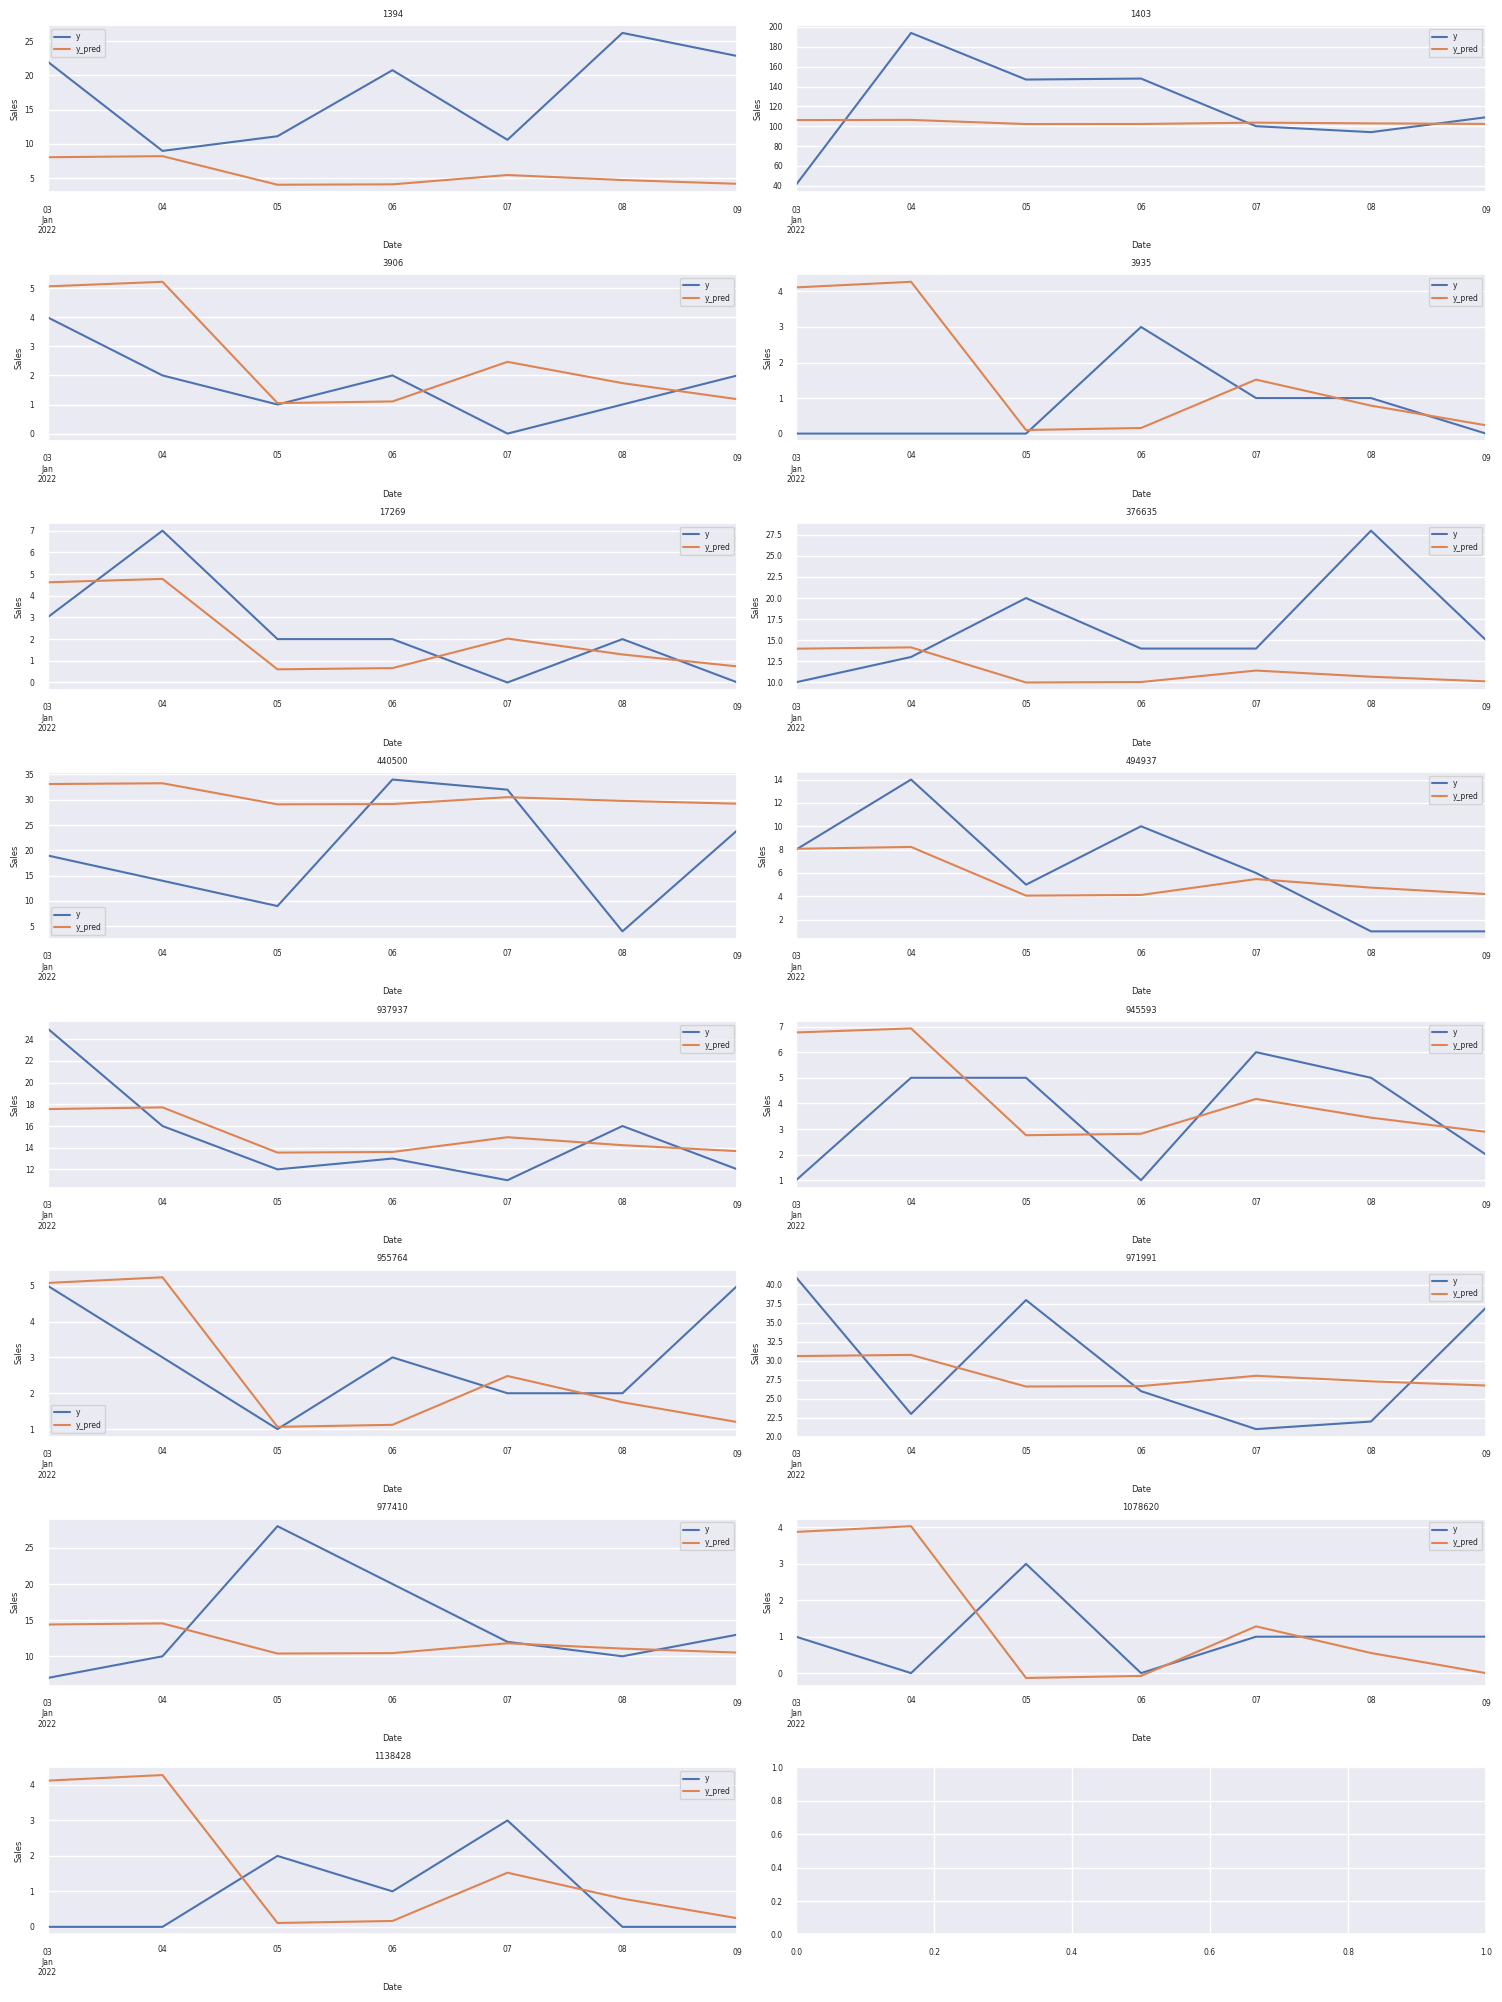

In [20]:
# Graficamos las predicciones vs el valor real para cada item
sns.set(font_scale=.5) 

fig, ax = plt.subplots(8,2, figsize=(15,20))
ax = ax.flatten()
for ax_ ,item_id in enumerate(sorted(df_predictions['item_id'].unique())):
    p_ = df_predictions.loc[(df_predictions['item_id'] == item_id)] 
    p_.plot(x='ds', y='y', ax=ax[ax_], label='y')
    p_.plot(x='ds', y='yhat', ax=ax[ax_], label='y_pred')
    ax[ax_].set_title(item_id)
    ax[ax_].legend()
    ax[ax_].set_xlabel('Date')
    ax[ax_].set_ylabel('Sales')
fig.tight_layout()
plt.show()

Calulamos el Mean Absolute Error y Root Mean Square Error.

In [21]:
# Métricas que vamos a utlizar para evaluar los resultados
def prediction_mae(y_true, y_pred):
    return np.mean(np.abs(y_pred - y_true))

def prediction_rmse(y_true, y_pred):
    return np.sqrt(np.mean((y_pred - y_true)**2))

In [22]:
# Crear listas para almacenar los resultados
item_ids = []
pred_maes = []
pred_rmses = []

# Obtener los unique item_id del dataframe
unique_item_ids = df_predictions['item_id'].unique()

# Calcular las métricas para cada item_id
for item_id in unique_item_ids:
    # Filtrar el dataframe por item_id
    item_df = df_predictions[df_predictions['item_id'] == item_id]

           
    # Calcular las métricas
    mae = prediction_mae(item_df['y'], item_df['yhat'])
    rmse = prediction_rmse(item_df['y'], item_df['yhat'])
    
    # Almacenar los resultados en las listas
    item_ids.append(item_id)
    pred_maes.append(mae)
    pred_rmses.append(rmse)

# Crear el DataFrame con los resultados
pred_errors = pd.DataFrame({'item_id': item_ids, 
                            'pred_mae': pred_maes, 
                            'pred_rmse': pred_rmses})

pred_errors

,item_id,pred_mae,pred_rmse
0,3906,1.320461,1.672627
1,937937,2.675208,3.437979
2,955764,1.255271,1.824342
3,376635,6.281548,8.150300
4,440500,12.974443,15.547932
5,1403,37.513590,48.071360
6,17269,1.434819,1.532422
7,1138428,1.947909,2.461876
8,977410,6.125426,8.319884
9,1078620,1.693998,2.257748


Al analizar los errores de predicción, es evidente que el modelo XGBoost es el que ofrece los mejores resultados. Se observa una reducción significativa en el MSE, incluso para las series con valores de ventas altos. Además, este modelo demuestra ser computacionalmente más eficiente, permitiendo realizar predicciones para todos los items en un tiempo considerablemente menor en comparación con otros enfoques.

Sin duda, podemos continuar iterando en este modelo para lograr un ajuste aún mejor. Una opción válida sería explorar la posibilidad de crear modelos por rubro o incluso por item_id, lo cual requeriría una investigación adicional.

Además, vale la pena mencionar que existen modelos basados en redes neuronales, como el modelo LSTM, que también pueden ser utilizados para realizar pronósticos. Estos modelos, al ser capaces de capturar dependencias secuenciales en los datos, podrían proporcionar resultados prometedores en términos de precisión y capacidad de ajuste.

Más allá de los resultados obtenidos, es importante tener en cuenta que existen dos enfoques principales en el desarrollo de modelos: el enfoque model-centric y el enfoque data-centric. En el enfoque model-centric, se pone un mayor énfasis en el diseño y la complejidad del modelo utilizado, pero sobre todo en la selección de algoritmos y técnicas avanzadas. Sin embargo, en el enfoque data-centric se prioriza la calidad y la disponibilidad de los datos utilizados para entrenar el modelo.

En muchos casos, agregar más información al modelo, features, puede mejorar significativamente las predicciones. Esto implica recolectar o crear otras featuers que aporten información al modelo. Por otro lado, la calidad de los datos desempeña un papel fundamental en el rendimiento del modelo. Datos incompletos, ruidosos o sesgados pueden afectar negativamente la capacidad predictiva.

Eligiremos este modelo para diseñar la librería. Para esto necesitamos:

1. Definir la estructura de la librería: dividirla en módulos o clases según las diferentes funcionalidades que deseemos implementar.

2. Recopilar y preprocesar los datos: crear funciones o clases que permitan cargar los datos de ventas históricas en el formato adecuado para su procesamiento. Realiza cualquier preprocesamiento necesario, como la limpieza de datos faltantes o la transformación de variables.

3. Entrenamiento del modelo: se debería diseñar funciones o clases que permitan entrenar modelos de predicción de ventas. Implementar métodos para ajustar los hiperparámetros del modelo y evaluar su rendimiento.

4. Generar las predicciones: crear funciones o métodos que utilicen los modelos entrenados para generar predicciones de ventas futuras.

5. Evaluación y métricas: Implementa funciones o métodos para evaluar el rendimiento de las predicciones utilizando métricas relevantes.

6. Documentación y ejemplos de uso: Proporciona una documentación clara y completa para tu librería, incluyendo descripciones de funciones, clases y parámetros. También puedes incluir ejemplos de uso que guíen a los usuarios sobre cómo utilizar tu librería para realizar predicciones de ventas.

Referencias:
- https://www.kaggle.com/code/robikscube/tutorial-time-series-forecasting-with-xgboost